In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from unidecode import unidecode

pd.options.display.float_format = "{:,.2f}".format
sns.set_theme(style='white')

# Config

In [2]:
# PATH_SAMPLES = 'data/reference/banco_14_amostraDMR_preenchido.xlsx'
PATH_SAMPLES = 'data/reference/banco_13_amostraGR.xlsx'

PATH_DATAFRAME = 'data/banco_carnes_un_v6_ed.parquet'

TARGET_FIELDS_SP = ['dados.n_doc', 'item','qt_nova', 'valor_kg', 'valor','valor_novo']

TARGE_FIELDS_DF = ['dados.n_doc', 'item','unit_kg', 'price_kg', 'valor']

CODE = 13

# Input

In [3]:
df_samples = pd.read_excel(PATH_SAMPLES).fillna(0).query('valor_kg > 0')

df_samples['item'] = df_samples['item'].str.upper().apply(unidecode)

df_products = pd.read_parquet(PATH_DATAFRAME).query(f'codigo == {CODE} and rule_apply == 1 and outlier == 0')

# Create key

In [4]:
df_samples['key'] = (
    df_samples['ano'].astype(str) + "_" +
    #df_samples['dados.CNPJ.CPF'].astype(str) + "_" +
    df_samples['un'].astype(str) + "_" +
    df_samples['qt'].astype(str) + "_" +
    df_samples['item'].astype(str) + "_" 
)

df_products['key'] = (
    df_products['ano'].astype(str) + "_" +
    #df_products['dados.CNPJ.CPF'].astype(str) + "_" +
	df_products['un'].astype(str) + "_" +
    df_products['qt'].astype(str) + "_" +
    df_products['item'].astype(str) + "_" 

)

# Merge Dataframes

In [5]:
df_products['valor_novo_s'] = df_products['price_kg'].mul(df_products['unit_kg'])

df_merged = df_samples.merge(
    df_products, 
    how='inner', 
    on='key'
)[['ano_x','item_x','qt_nova','unit_kg', 'valor_kg',  'price_kg', 'valor_x', 'valor_y', 'valor_novo', 'valor_novo_s']]

# Compute Diff

In [6]:
df_merged['price_kg_diff'] = df_merged['valor_kg'].subtract(df_merged['price_kg'])
df_merged['valor_diff'] = df_merged['valor_novo'].subtract(df_merged['valor_y'])

# Change DF structure

In [7]:
df_price_un = df_merged[['ano_x','price_kg', 'valor_kg']]\
    .melt(id_vars=['ano_x'], value_vars=['price_kg', 'valor_kg'], var_name='type')\
	.replace({'type': {'price_kg': 'Estimado', 'valor_kg': 'Amostra'}})

df_qt = df_merged[['ano_x','qt_nova', 'unit_kg']]\
    .melt(id_vars=['ano_x'], value_vars=['qt_nova', 'unit_kg'], var_name='type')\
	.replace({'type': {'unit_kg': 'Estimado', 'qt_nova': 'Amostra'}})

df_valor = df_merged[['ano_x','valor_novo', 'valor_novo_s']]\
    .melt(id_vars=['ano_x'], value_vars=['valor_novo', 'valor_novo_s'], var_name='type')\
	.replace({'type': {'valor_novo_s': 'Estimado', 'valor_novo': 'Amostra'}})

# Display charts

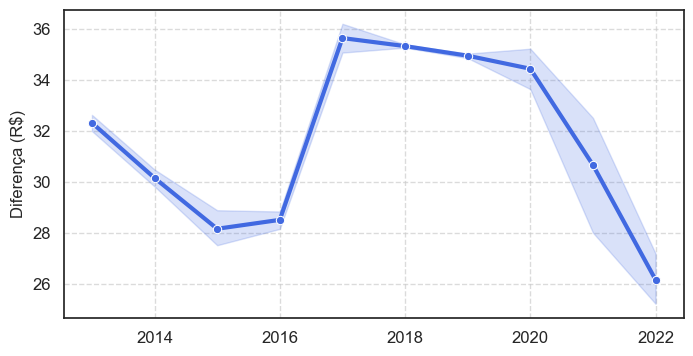

In [8]:
# Criar figura
plt.figure(figsize=(8, 4))

# Criar gráfico de linha com melhorias
sns.lineplot(
    data=df_merged, 
    x='ano_x', 
    y='price_kg_diff', 
    marker="o",  # Adiciona marcadores nos pontos
    linewidth=3,  # Linhas mais espessas
    color="royalblue"  # Cor mais destacada
)

# Ajustar eixos
plt.xlabel('')
plt.ylabel('Diferença (R$)', fontsize=12)
#plt.ylim(0, 10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Melhorar layout
plt.grid(True, linestyle="--", alpha=0.7)  # Grade mais discreta

plt.savefig(f'data/figures/{CODE}_difference_price_kg.png')
plt.show()

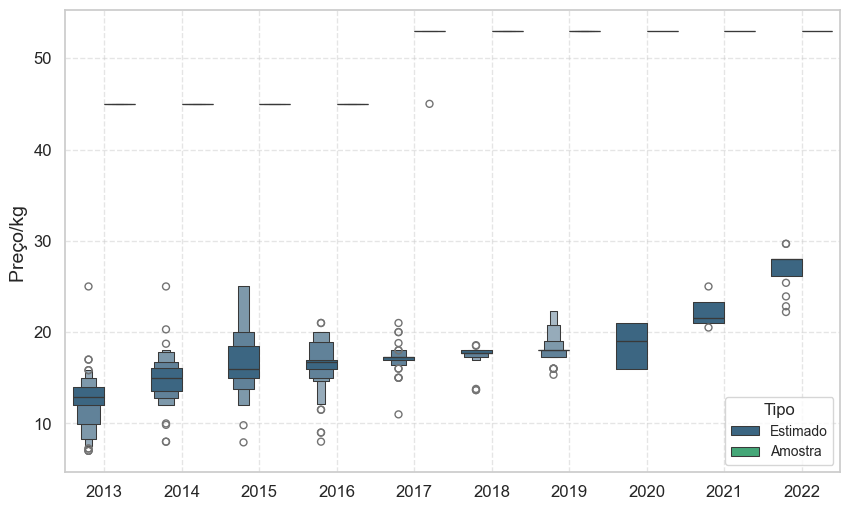

In [9]:
import seaborn as sns
sns.set_theme(style="whitegrid")


plt.figure(figsize=(10, 6))


sns.boxenplot(
    data=df_price_un, 
    x="ano_x", 
    y="value",
    hue="type", 
    width_method="linear",
    palette="viridis"  
)


plt.xlabel('')
plt.ylabel('Preço/kg ', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Melhorar legenda
plt.legend(title="Tipo", loc="lower right", fontsize=10, title_fontsize=12)

# Melhorar grade
plt.grid(True, linestyle="--", alpha=0.5)


plt.savefig(f'data/figures/{CODE}_comparasion_price_kg.png')
# Exibir gráfico
plt.show()



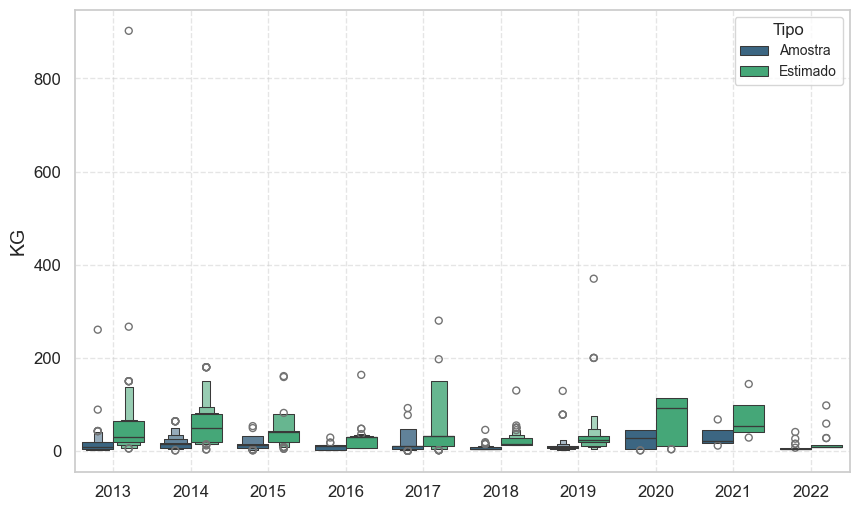

In [10]:
import seaborn as sns
sns.set_theme(style="whitegrid")


plt.figure(figsize=(10, 6))


sns.boxenplot(
    data=df_qt, 
    x="ano_x", 
    y="value",
    hue="type", 
    width_method="linear",
    palette="viridis"  
)


plt.xlabel('')
plt.ylabel('KG', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Melhorar legenda
plt.legend(title="Tipo", loc="upper right", fontsize=10, title_fontsize=12)

# Melhorar grade
plt.grid(True, linestyle="--", alpha=0.5)

plt.savefig(f'data/figures/{CODE}_comparasion_count_kg.png')
# Exibir gráfico
plt.show()



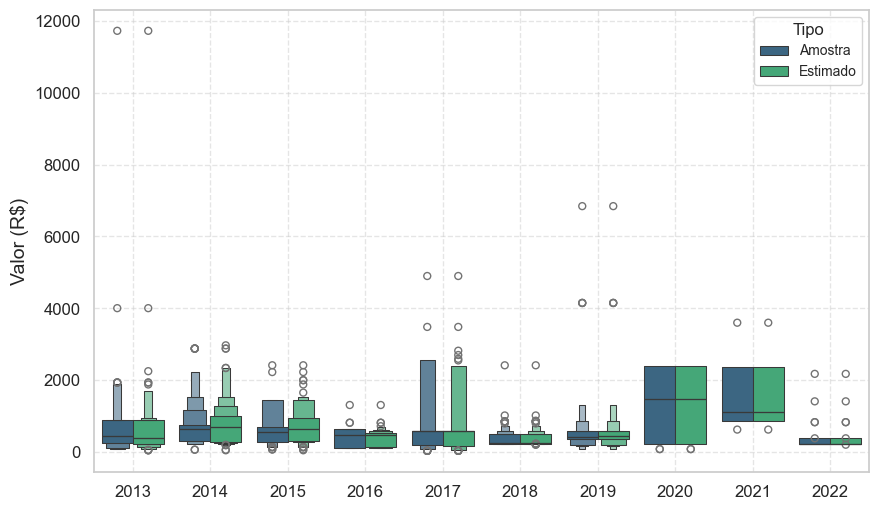

In [11]:
import seaborn as sns
sns.set_theme(style="whitegrid")


plt.figure(figsize=(10, 6))


sns.boxenplot(
    data=df_valor, 
    x="ano_x", 
    y="value",
    hue="type", 
    width_method="linear",
    palette="viridis"  
)


plt.xlabel('')
plt.ylabel('Valor (R$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Melhorar legenda
plt.legend(title="Tipo", loc="upper right", fontsize=10, title_fontsize=12)

# Melhorar grade
plt.grid(True, linestyle="--", alpha=0.5)



plt.savefig(f'data/figures/{CODE}_comparasion_valor_kg.png')
# Exibir gráfico
plt.show()


In [12]:
df_merged.to_csv(f'data/produto_{CODE}_comparacao.csv')

# 